In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [2]:
##PC:
path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Yearly point extraction data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  ## more options can be specified also
#     print(df)

# df = df[df['Species_Code'] == 'A1'] ##eventually, you will want to do this

# ntimes = 16 # number of times you repeat each item
# yourlist = [2000,2001,2002,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
# df['Year'] = [i for i in yourlist for _ in range(ntimes)]

df

# print(df.iloc[100,])

# for col in df.columns:
#     print(col)

,B1,B2,B3,B4,B5,B6,B7,flats,system:index,latitude,...,Year,speciesName,locationID,liveMass,Transect,longitude,totalMass,deadMass,B10,B11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,37.395746,...,2000,Spartina alterniflora,1,841.6,B,-75.876094,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,37.395746,...,2000,Spartina alterniflora,1,214.4,B,-75.876094,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,37.395746,...,2000,Spartina alterniflora,1,963.2,C,-75.876094,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,37.395746,...,2000,Spartina alterniflora,1,0.0,C,-75.876094,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,37.395746,...,2000,Spartina alterniflora,1,841.6,A,-75.876094,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,0.0436,0.0621,0.0666,0.1545,0.1194,0.2973,0.0595,0.000065,189,37.481998,...,1999,Spartina alterniflora,3,0.0,B,-75.819360,977.60,977.60,NaN,NaN
1860,0.0395,0.0579,0.0567,0.1117,0.0808,0.2964,0.0522,0.012653,190,37.481998,...,1999,Spartina alterniflora,1,129.6,C,-75.819360,185.60,56.00,NaN,NaN
1861,0.0395,0.0498,0.0470,0.1389,0.1169,0.2964,0.0631,0.000299,191,37.481998,...,1999,Spartina alterniflora,2,388.8,C,-75.819360,574.40,185.60,NaN,NaN
1862,0.0395,0.0498,0.0470,0.1389,0.1169,0.2964,0.0631,0.000299,192,37.481998,...,1999,Spartina alterniflora,2,315.2,C,-75.819360,643.20,328.00,NaN,NaN


In [3]:
##Bands and indices

df['Sensor'] = np.where(df['Year']<2013, 'Landsat 5', 'Landsat 8') ##make sure no other sensors are being used

df['ndvi'] = np.where(df['Sensor'] == 'Landsat 5', (df['B4']-df['B3'])/(df['B4']+df['B3']), \
                      (df['B5']-df['B4'])/(df['B5']+df['B4'])) ##ndvi conditional based on whether sensor is Landsat-5 or 8

df['Blue_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B1'], df['B2'])
df['Green_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B2'], df['B3'])
df['Red_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B3'], df['B4'])
df['NIR_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B4'], df['B5'])
df['SWIR1_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B5'], df['B6'])
df['SWIR2_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B7'], df['B7'])

##IMPORTANT: again, these bands between landsat 5 and 8 may not be able to be compared directly

##Variables from Byrd et al. 2018 (make sure calculations are accurate):
df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

df = df.drop(columns=['latitude','longitude'])
df['ident'] = df['Latitude'] / df['Longitude'] + df['Year'] ##Just crazy enough that it might work

df

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df)

,B1,B2,B3,B4,B5,B6,B7,flats,system:index,marshName,...,NIR_band,SWIR1_band,SWIR2_band,savi,wdrvi5,nd_r_g,nd_g_b,nd_swir2_nir,nd_swir2_r,ident
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Box Tree,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999.507147
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Box Tree,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999.507147
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Box Tree,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999.507143
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,Box Tree,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999.507143
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,Box Tree,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999.507152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,0.0436,0.0621,0.0666,0.1545,0.1194,0.2973,0.0595,0.000065,189,Woodland Farm,...,0.1545,0.1194,0.0595,0.182846,0.074035,0.034965,0.175024,-0.443925,-0.056305,1998.505641
1860,0.0395,0.0579,0.0567,0.1117,0.0808,0.2964,0.0522,0.012653,190,Woodland Farm,...,0.1117,0.0808,0.0522,0.123429,-0.007552,-0.010471,0.188912,-0.363026,-0.041322,1998.505646
1861,0.0395,0.0498,0.0470,0.1389,0.1169,0.2964,0.0631,0.000299,191,Woodland Farm,...,0.1389,0.1169,0.0631,0.200977,0.192787,-0.028926,0.115342,-0.375248,0.146231,1998.505647
1862,0.0395,0.0498,0.0470,0.1389,0.1169,0.2964,0.0631,0.000299,192,Woodland Farm,...,0.1389,0.1169,0.0631,0.200977,0.192787,-0.028926,0.115342,-0.375248,0.146231,1998.505647


In [4]:
# df = df[df['ndvi'].notna()] ##later?
# df['siteName'] = df['site_id'].copy()

# display(df)
# for col in df.columns:
#     print(col)

In [5]:
##Average plot value (grouped, more or less, by lat/long, for each year)

# va_means = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Average biomass/va_meanmass.csv')
# display(va_means)

# df_first = pd.merge(df, va_means)
# df_first ##n is boiled down to 92 here - at first glance it looks correct, but make sure it is!


In [6]:
##Daymet data; yearly average
path2 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/VA/Yearly averages' 
all_files2 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files2:
    dm = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm)

dm = pd.concat(li, axis=0, ignore_index=True)

dm.rename(columns={'site_id':'siteName'}, inplace=True)
dm = dm.drop(columns=['latitude','longitude'])

# dm['ident'] = dm['Latitude']/dm['Longitude']

dm['ident'] = dm['Latitude'] / dm['Longitude'] + dm['Year'] ##Just crazy enough that it might work

display(dm)

,dayl,prcp,srad,swe,tmax,tmin,vp,system:index,marshName,siteName,...,Code,Longitude,monitoringPurpose,Replicate,Year,speciesName,locationID,liveMass,Transect,ident
0,43225.171875,3.546236,311.112579,0.000000,20.336401,10.515385,1439.916382,0,Box Tree,Box_Tree,...,BTCC,-75.876056,EOYB,b,1999,Spartina alterniflora,1,0.00,C,1998.507143
1,43225.171875,3.555687,311.353333,0.000000,20.326044,10.495000,1437.849121,1,Box Tree,Box_Tree,...,BTC2,-75.877045,EOYB,b,1999,Spartina alterniflora,3,272.48,C,1998.507144
2,43225.171875,3.546236,311.112579,0.000000,20.336401,10.515385,1439.916382,2,Box Tree,Box_Tree,...,BTDC,-75.875969,EOYB,b,1999,Spartina alterniflora,1,0.00,D,1998.507139
3,43225.171875,3.555687,311.353333,0.000000,20.326044,10.495000,1437.849121,3,Box Tree,Box_Tree,...,BTAC,-75.876249,EOYB,b,1999,Spartina alterniflora,1,0.00,A,1998.507152
4,43225.171875,3.555687,311.353333,0.000000,20.326044,10.495000,1437.849121,4,Box Tree,Box_Tree,...,BTA3,-75.878189,EOYB,b,1999,Spartina alterniflora,4,0.00,A,1998.507153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,43225.062500,3.305769,310.027924,0.000000,20.746950,11.474368,1548.789673,32,Oyster,Oyster,...,OSBC,-75.929133,EOYB,b,2017,Spartina alterniflora,1,480.00,B,2016.508916
1860,43225.062500,3.305769,310.027924,0.000000,20.746950,11.474368,1548.789673,33,Oyster,Oyster,...,OSBC,-75.929133,EOYB,a,2017,Spartina alterniflora,1,402.88,B,2016.508916
1861,43224.957031,3.342610,307.995300,0.000000,21.011868,11.759917,1576.207886,34,Gator Tract,Gator,...,GTC2,-75.944280,EOYB,a,2017,Spartina alterniflora,3,42.72,C,2016.510592
1862,43225.171875,3.430330,303.402832,1.031209,20.270796,11.017665,1547.654297,0,Box Tree,Box_Tree,...,BTCC,-75.876056,EOYB,a,2018,Spartina alterniflora,1,255.04,C,2017.507143


In [7]:
##Loading elevation data

elev_10m = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Point elevation/VA_DEM_vals_10m.csv')

elev_10m.rename(columns={'first':'Elevation'}, inplace=True)
elev_10m.rename(columns={'site_id':'siteName'}, inplace=True)

elev_10m['ident'] = elev_10m['Latitude'] / elev_10m['Longitude'] + elev_10m['Year'] ##Just crazy enough that it might work

print(len(elev_10m['Elevation'].unique()))

display(elev_10m) ##More data here than other datasets

153


,Elevation,system:index,latitude,marshName,siteName,Latitude,Code,Longitude,monitoringPurpose,Replicate,Year,speciesName,locationID,liveMass,Transect,longitude,ident
0,0.957294,0,37.395746,Box Tree,Box_Tree,37.396051,BTCC,-75.876056,EOYB,b,1999,Spartina alterniflora,1,0.00,C,-75.876094,1998.507143
1,0.967578,1,37.395746,Box Tree,Box_Tree,37.396450,BTC2,-75.877045,EOYB,b,1999,Spartina alterniflora,3,272.48,C,-75.876094,1998.507144
2,0.678239,2,37.395746,Box Tree,Box_Tree,37.396337,BTDC,-75.875969,EOYB,b,1999,Spartina alterniflora,1,0.00,D,-75.876094,1998.507139
3,0.396057,3,37.395746,Box Tree,Box_Tree,37.395461,BTAC,-75.876249,EOYB,b,1999,Spartina alterniflora,1,0.00,A,-75.876094,1998.507152
4,1.019467,4,37.395746,Box Tree,Box_Tree,37.396366,BTA3,-75.878189,EOYB,b,1999,Spartina alterniflora,4,0.00,A,-75.876094,1998.507153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,0.428171,1859,37.287549,Oyster,Oyster,37.287549,OSBC,-75.929133,EOYB,b,2017,Spartina alterniflora,1,480.00,B,-75.929133,2016.508916
1860,0.428171,1860,37.287549,Oyster,Oyster,37.287549,OSBC,-75.929133,EOYB,a,2017,Spartina alterniflora,1,402.88,B,-75.929133,2016.508916
1861,0.681341,1861,37.167409,Gator Tract,Gator,37.167768,GTC2,-75.944280,EOYB,a,2017,Spartina alterniflora,3,42.72,C,-75.940586,2016.510592
1862,0.957294,1862,37.395746,Box Tree,Box_Tree,37.396051,BTCC,-75.876056,EOYB,a,2018,Spartina alterniflora,1,255.04,C,-75.876094,2017.507143


In [8]:
##Merging daymet, elevation, and flats data
df['dropident'] = df['Latitude']/df['Longitude']*df['Year']+df['liveMass']
dm['dropident'] = dm['Latitude']/dm['Longitude']*dm['Year']+dm['liveMass']
elev_10m['dropident'] = elev_10m['Latitude']/elev_10m['Longitude']*elev_10m['Year']+elev_10m['liveMass']

df0 = pd.merge(df, dm, on = ['dropident'], how = 'left')

#Rationale: By using a combination of lat/long, year, and biomass, drop all unnecessary duplicates
df0['dropident'] = df0['Latitude_x']/df0['Longitude_x']*df0['Year_x']+df0['liveMass_x']
print(len(df0['dropident']))

df0 = df0.drop_duplicates(
  subset = ['dropident'],
  keep = 'last').reset_index(drop = True)

print(len(df0['dropident']))


##Merge with elevation
df1 = pd.merge(df0, elev_10m, on = ['dropident'], how = 'left')

# df1 = pd.merge(df0, elev_10m, on = ['ident', 'Replicate'], how = 'left')

df1['dropident'] = df1['Latitude_x']/df1['Longitude_x']*df1['Year_x']+df1['liveMass_x']
print(len(df1['dropident']))

df1 = df1.drop_duplicates(
  subset = ['dropident'],
  keep = 'last').reset_index(drop = True)

print(len(df1['dropident']))

##Duplicates  - df1 MUST VBE cross-referenced with df (original)
# display(df0)
display(df1)

##THIS NEEDS TO BE 0
print('df0 biomass diff is: '+str(sum(df0['liveMass_x'] - df0['liveMass_y'])))
print('df1 biomass diff (x-y) is: '+str(sum(df1['liveMass_x'] - df1['liveMass_y'])))
print('df1 biomass diff (x-z) is: '+str(sum(df1['liveMass_x'] - df1['liveMass'])))
# df1.rename(columns={'liveMass_x':'liveMass'}, inplace=True)

print("biomass measurements: " + str(len(df1['liveMass'])))
print(len(df1['Elevation'].unique()))

df1 = df1.drop(columns = ['latitude', 'longitude']) ##lower case ones are the older values

# for col in df1.columns:
#     print(col)

out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'df1.csv')
# df1.to_csv(out_csv, index = False)

1900
1846
1864
1846


,B1,B2,B3,B4,B5,B6,B7,flats,system:index_x,marshName_x,...,Longitude,monitoringPurpose,Replicate,Year,speciesName,locationID,liveMass,Transect,longitude,ident
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Box Tree,...,-75.876094,EOYB,a,2000,Spartina alterniflora,1,841.6,B,-75.876094,1999.507147
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Box Tree,...,-75.876094,EOYB,b,2000,Spartina alterniflora,1,214.4,B,-75.876094,1999.507147
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Box Tree,...,-75.876056,EOYB,a,2000,Spartina alterniflora,1,963.2,C,-75.876094,1999.507143
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,Box Tree,...,-75.876056,EOYB,b,2000,Spartina alterniflora,1,0.0,C,-75.876094,1999.507143
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,Box Tree,...,-75.876249,EOYB,a,2000,Spartina alterniflora,1,841.6,A,-75.876094,1999.507152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841,0.0416,0.0580,0.0601,0.1428,0.1194,0.2968,0.0741,0.000083,188,Woodland Farm,...,-75.819185,EOYB,b,1999,Spartina alterniflora,2,249.6,B,-75.819360,1998.505641
1842,0.0395,0.0579,0.0567,0.1117,0.0808,0.2964,0.0522,0.012653,190,Woodland Farm,...,-75.819638,EOYB,a,1999,Spartina alterniflora,1,129.6,C,-75.819360,1998.505646
1843,0.0395,0.0498,0.0470,0.1389,0.1169,0.2964,0.0631,0.000299,191,Woodland Farm,...,-75.819201,EOYB,a,1999,Spartina alterniflora,2,388.8,C,-75.819360,1998.505647
1844,0.0395,0.0498,0.0470,0.1389,0.1169,0.2964,0.0631,0.000299,192,Woodland Farm,...,-75.819201,EOYB,b,1999,Spartina alterniflora,2,315.2,C,-75.819360,1998.505647


df0 biomass diff is: 0.0
df1 biomass diff (x-y) is: 0.0
df1 biomass diff (x-z) is: 0.0
biomass measurements: 1846
153


In [9]:
##Some more data massaging
df1 = df1[df1['ndvi'].notna()]
df1 = df1[df1['liveMass'].notna()]
df1 = df1[df1['Latitude'].notna()]
df1 = df1[(df1['flats'] < 0.1)] ##Double check

##Group df1 and average (midpoint) the replicates (a/b)
df_temp=df1.copy()

df_temp = df_temp.groupby(['Year','locationID','Transect','Latitude','Longitude'],as_index = False).aggregate(
    {
        'liveMass':[np.mean, np.size],'ndvi':[np.mean],'nd_swir2_r':[np.mean],'nd_swir2_nir':[np.mean],'nd_g_b':[np.mean],
        'nd_r_g':[np.mean],'wdrvi5':[np.mean],'savi':[np.mean],'Elevation':[np.mean],'prcp':[np.mean],'dayl':[np.mean],
        'tmax':[np.mean],'tmin':[np.mean],'srad':[np.mean],'vp':[np.mean]
    }
)

df_temp.columns = [
    'Year','locationID','Transect','Latitude','Longitude','liveMass','N','ndvi','nd_swir2_r','nd_swir2_nir', 'nd_g_b', 
    'nd_r_g', 'wdrvi5', 'savi', 'Elevation','prcp', 'dayl','tmax','tmin','srad','vp'
]

display(df_temp)

,Year,locationID,Transect,Latitude,Longitude,liveMass,N,ndvi,nd_swir2_r,nd_swir2_nir,...,nd_r_g,wdrvi5,savi,Elevation,prcp,dayl,tmax,tmin,srad,vp
0,1999,1,A,37.345970,-75.901065,875.52,2,0.499507,0.257923,-0.277311,...,-0.012330,0.199369,0.283360,0.476658,3.649863,43225.117188,20.414724,10.534066,311.316711,1442.590454
1,1999,1,A,37.395461,-75.876249,0.00,1,0.529725,0.237044,-0.334710,...,0.007605,0.238506,0.320546,0.396057,3.555687,43225.171875,20.326044,10.495000,311.353333,1437.849121
2,1999,1,A,37.451262,-75.672535,864.00,1,0.630313,0.138249,-0.539036,...,-0.075783,0.375973,0.357125,0.833658,3.272280,43225.226562,19.987225,10.622115,310.501709,1445.532959
3,1999,1,A,37.482293,-75.819265,104.00,2,0.319794,0.321543,0.001950,...,0.075982,-0.015155,0.183658,0.744798,3.288764,43225.281250,20.177252,10.398517,312.960846,1424.362183
4,1999,1,B,37.395746,-75.876094,212.88,2,0.525200,0.189242,-0.373034,...,0.003025,0.232585,0.323952,0.107919,3.546236,43225.171875,20.336401,10.515385,311.112579,1439.916382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2017,3,A,37.407757,-75.697233,18.88,2,0.441860,0.110287,-0.348559,...,-0.040959,0.127273,0.169643,0.607121,3.578928,43225.171875,20.562885,11.365109,307.891052,1535.228271
607,2017,3,B,37.174970,-75.943949,121.44,2,0.662217,0.225623,-0.513284,...,-0.074830,0.422045,0.389186,0.705047,3.357912,43224.957031,20.968325,11.728791,308.119415,1573.322876
608,2017,3,B,37.287875,-75.929008,96.08,2,0.706891,0.241841,-0.560947,...,-0.095808,0.488713,0.405080,1.035588,3.305769,43225.062500,20.746950,11.474368,310.027924,1548.789673
609,2017,3,C,37.167768,-75.944280,26.56,2,0.479947,0.123874,-0.378580,...,0.012362,0.174536,0.269520,0.681341,3.342610,43224.957031,21.011868,11.759917,307.995300,1576.207886


In [30]:
##Careful of dfx vs df1!

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from numpy import loadtxt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor ##try KNN next!
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

df1 = df_temp ##Therein the rub! COMMENT OUT if you do not want to group replicates

xargs=df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
           'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp']]

yargs=df1['liveMass'] 

print("biomass measurements: " + str(len(df1['liveMass'])))
print("yargs: " + str(len(yargs)))

size_x = 0.2
seed = 3
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test

pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, y_pred))/np.ptp(yargs_test)))

# Mean
print('MEAN BASELINE:')
y_pred_mean = [np.mean(yargs_train)] * len(yargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred_mean)))


##For replicate averaged dataset, a little better than the mean baseline! NEED TO IMPROVE

biomass measurements: 611
yargs: 611
Mean Absolute Error: 224.39342166473094
Mean Squared Error: 102045.4309597624
Root Mean Squared Error: 319.4455054618274
The r squared is: 0.19943353562331823
0.19943353562331823
testing r2 is: 0.19943353562331823
training r2 is: 0.877258892436646
NRMSE is: 0.12555635689314978
MEAN BASELINE:
Mean Absolute Error: 271.943173752721
Root Mean Squared Error: 364.2745065572415


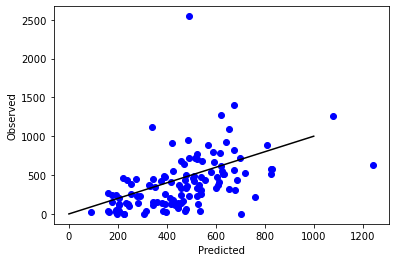

test data correlation coefficient is: 0.48171998808076644
train data correlation coefficient is: 0.9612479377963934


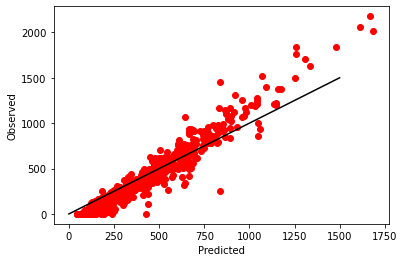

In [31]:
plt.scatter(y_pred, yargs_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 1000], [0, 1000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(yargs_test, y_pred)[0, 1]))

train_pred = pipe.predict(xargs_train) ##Not sure if this is the right thing to do here
plt.scatter(train_pred, yargs_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 1500], [0, 1500], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(train_pred, yargs_train)[0, 1]))

In [100]:
##k-fold cross validation; similar to original random forest regression code

predictors = df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi']]
targets = df1['liveMass'] 

from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import KFold, cross_validate
from sklearn.datasets import load_boston

X, y = predictors, targets
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

model = pipe
scoring=('r2', 'neg_root_mean_squared_error')

cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)
cv_results

##from: https://stackoverflow.com/questions/55270431/how-to-correctly-perform-cross-validation-in-scikit-learn

{'fit_time': array([0.19278765, 0.18720722, 0.20307851, 0.20307994, 0.21754384]),
 'score_time': array([0.01552796, 0.01562262, 0.        , 0.        , 0.00897431]),
 'test_r2': array([-0.01475223,  0.01232289,  0.0758588 ,  0.08889979,  0.01737591]),
 'test_neg_root_mean_squared_error': array([-398.87017257, -425.00266553, -302.30609293, -368.44310982,
        -300.22526495])}

In [103]:
##Comparing with standard empirical model -- just uncomment and run

##sklearn - linear_regressor L1 weights look at these

print(len(xargs))
print(len(yargs))

print(xargs.head())

from sklearn import linear_model
import statsmodels.api as sm

regr = linear_model.LinearRegression()
regr.fit(xargs, yargs)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
xargs = sm.add_constant(xargs) ##adding a constant
 
model = sm.OLS(yargs, xargs).fit()
predictions = model.predict(xargs) 
 
print_model = model.summary()
print(print_model) ##check model assumptions

611
611
   const      ndvi  nd_swir2_r  nd_swir2_nir    nd_g_b    nd_r_g    wdrvi5  \
0    1.0  0.499507    0.257923     -0.277311  0.209302 -0.012330  0.199369   
1    1.0  0.529725    0.237044     -0.334710  0.206471  0.007605  0.238506   
2    1.0  0.630313    0.138249     -0.539036  0.236742 -0.075783  0.375973   
3    1.0  0.319794    0.321543      0.001950  0.175860  0.075982 -0.015155   
4    1.0  0.525200    0.189242     -0.373034  0.212656  0.003025  0.232585   

       savi  Elevation      prcp          dayl       tmax       tmin  \
0  0.283360   0.476658  3.649863  43225.117188  20.414724  10.534066   
1  0.320546   0.396057  3.555687  43225.171875  20.326044  10.495000   
2  0.357125   0.833658  3.272280  43225.226562  19.987225  10.622115   
3  0.183658   0.744798  3.288764  43225.281250  20.177252  10.398517   
4  0.323952   0.107919  3.546236  43225.171875  20.336401  10.515385   

         srad           vp  
0  311.316711  1442.590454  
1  311.353333  1437.849121  
2  

In [36]:
##xgboost - seems to perform worse than random forest, at least with initial data
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## split data into X and y
xargs=df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
           'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp']]
yargs=df1['liveMass'] 

## split data into train and test sets
size_x = 0.2
seed = 0
x_xg_train, x_xg_test, y_xg_train, y_xg_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed)

##Feature Scaling 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_xg_train = sc.fit_transform(x_xg_train)
x_xg_test = sc.transform(x_xg_test)

##fit model no training data
xg_reg = XGBClassifier()
xg_reg.fit(x_xg_train, y_xg_train)

##make predictions for test data
y_xg_pred = xg_reg.predict(x_xg_test)
# predictions = [round(value) for value in y_pred]

##evaluate predictions

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_xg_test, y_xg_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_xg_test, y_xg_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_xg_test, y_xg_pred)))

r_square = metrics.r2_score(y_xg_test, y_xg_pred)
print(r_square)
# print(reg_x.score(x_xg_test, y_xg_test))

# accuracy = accuracy_score(yargs_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:42:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mean Absolute Error: 341.0656260162602
Mean Squared Error: 207594.46762354474
Root Mean Squared Error: 455.62535884599833
-0.7585261491416213


RMSE value for k=  1 is: 444.85375978976447
RMSE value for k=  2 is: 389.181687952129
RMSE value for k=  3 is: 352.7820821770237
RMSE value for k=  4 is: 343.08662039095105
RMSE value for k=  5 is: 335.0590137255171
RMSE value for k=  6 is: 324.95096187757605
RMSE value for k=  7 is: 324.6650598583405
RMSE value for k=  8 is: 318.08438315105076
RMSE value for k=  9 is: 313.698884512326
RMSE value for k=  10 is: 320.38233088178305
RMSE value for k=  11 is: 321.0861141943808
RMSE value for k=  12 is: 317.1251833147642
RMSE value for k=  13 is: 319.41979068119247
RMSE value for k=  14 is: 320.50319718100934
RMSE value for k=  15 is: 321.8079462484881
RMSE value for k=  16 is: 320.2498138399859
RMSE value for k=  17 is: 320.5017918868183
RMSE value for k=  18 is: 322.1867090443774
RMSE value for k=  19 is: 322.86426450319345
RMSE value for k=  20 is: 323.49481933410186


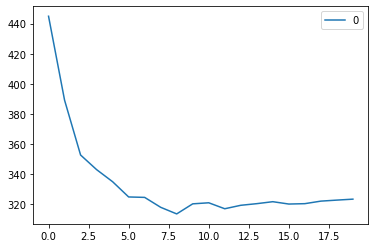

In [34]:
##KNN - be careful of site bias!! Data are spatially clustered based on site, also temporally clustered based on year

##Careful of overlap in variable names!

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

k_xargs=df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
           'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp']]

##Include lag variables (e.g. lag ndvi), precip, temp, more

k_yargs=df1['liveMass'] 

size_x = 0.2
seed = 0

k_xargs_train, k_xargs_test, k_yargs_train, k_yargs_test = \
train_test_split(k_xargs, k_yargs, test_size=size_x, random_state = seed)

## 80% training and 20% test

## Feature Scaling - does something weird with k values, what does that mean? Use minmax scaler instead (below), as in example?
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# xargs_train = sc.fit_transform(xargs_train)
# xargs_test = sc.transform(xargs_test)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
k_xargs_train = scaler.fit_transform(k_xargs_train)
k_xargs_test = scaler.fit_transform(k_xargs_test)

rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    k_model = neighbors.KNeighborsRegressor(n_neighbors = K)

    k_model.fit(k_xargs_train, k_yargs_train)  #fit the model
    k_pred=k_model.predict(k_xargs_test) #make prediction on test set
    k_error = sqrt(mean_squared_error(k_yargs_test, k_pred)) #calculate rmse
    rmse_val.append(k_error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', k_error)
    
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot() 

k_predict = k_model.predict(k_xargs_test)
##from: https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/


RMSE for KNN is: 335.0590137255171


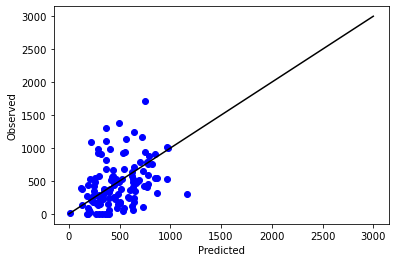

test data correlation coefficient is: 0.3601214646826173
train data correlation coefficient is: 0.6170228349128614


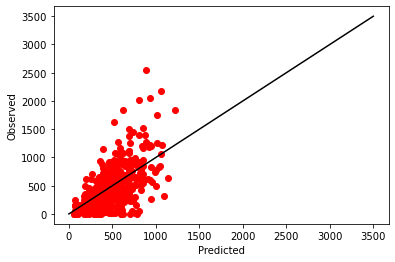

In [35]:
##KNN test results, plotted (careful of variable names overlap)
k_model = neighbors.KNeighborsRegressor(n_neighbors = 5)
k_model.fit(k_xargs_train, k_yargs_train)  #fit the model
k_pred=k_model.predict(k_xargs_test) #make prediction on test set
k_error = sqrt(mean_squared_error(k_yargs_test, k_pred))
print('RMSE for KNN is: ' + str(k_error))

plt.scatter(k_pred, k_yargs_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3000], [0, 3000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(k_yargs_test, k_pred)[0, 1]))

k_train_pred = k_model.predict(k_xargs_train) 
plt.scatter(k_train_pred, k_yargs_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3500], [0, 3500], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(k_train_pred, k_yargs_train)[0, 1]))

##Odd that the training data is not better